In [1]:
require(cowplot)
require(data.table)
require(ggplot2)
require(ggpubr)
require(scattermore)

Loading required package: cowplot

Warning message:
“replacing previous import ‘vctrs::data_frame’ by ‘tibble::data_frame’ when loading ‘dplyr’”

********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************


Loading required package: data.table

Loading required package: ggplot2

Loading required package: ggpubr


Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend


Loading required package: scattermore



In [2]:
dots_data = readRDS(file.path("/mnt/data/Imaging/202105-Deconwolf/data_210726",
                              "dots_data.rds"))[is.finite(SNR2) & SNR2 > 0 & Value2 > 0]
nuclear_features = fread("../../data/selected_nuclei.tsv", key=c("sid", "nid"))

# Panel 3.e: scatterplot of DoG-filtered intensity (Y) vs SNR (X), for 60x DW field #1.

In [3]:
ddata = dots_data[FWHM >= .5 & FWHM <= 5 & nid > 0]
setkeyv(ddata, c("series_id", "nid"))
ddata = nuclear_features[ddata][!is.na(size)]["60x" == magnification]["dw" == image_type]

In [4]:
ddata[, dot_type := "noisy dots"]
ddata[7 <= Value2, dot_type := "true dots"]

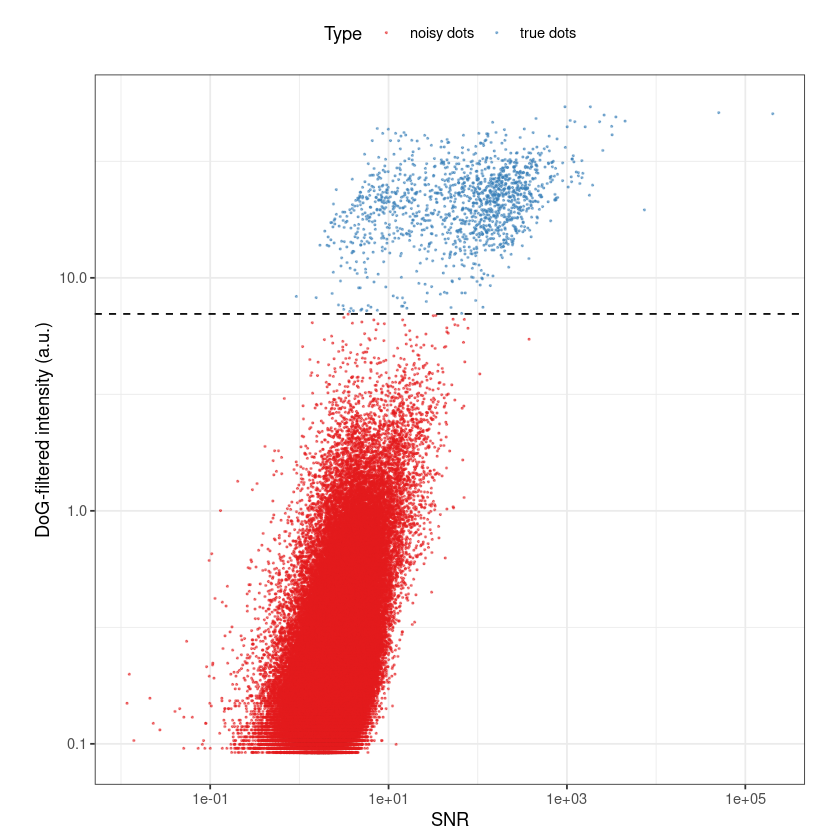

In [5]:
p = ggplot(ddata[1 == sid], aes(x=SNR2, y=Value2)) + geom_point(aes(color=dot_type), size=.25, alpha=.5) + theme_bw() +
    scale_x_log10() + scale_y_log10() + labs(x="SNR", y="DoG-filtered intensity (a.u.)") +
    scale_color_brewer("Type", palette="Set1") + theme(legend.position="top") +
    coord_fixed(ddata[1 == sid, diff(log10(range(SNR2)))/diff(log10(range(Value2)))]) +
    geom_hline(yintercept=7, color="black", linetype="dashed")
p

In [6]:
ggsave(plot=p, file="panels/fig_3e.png", width=4, height=4)
saveRDS(p, "panels_rds/fig_3e.rds")

# Panel 3.f: logged density distribution for threshold identification, in 60x raw field #1.

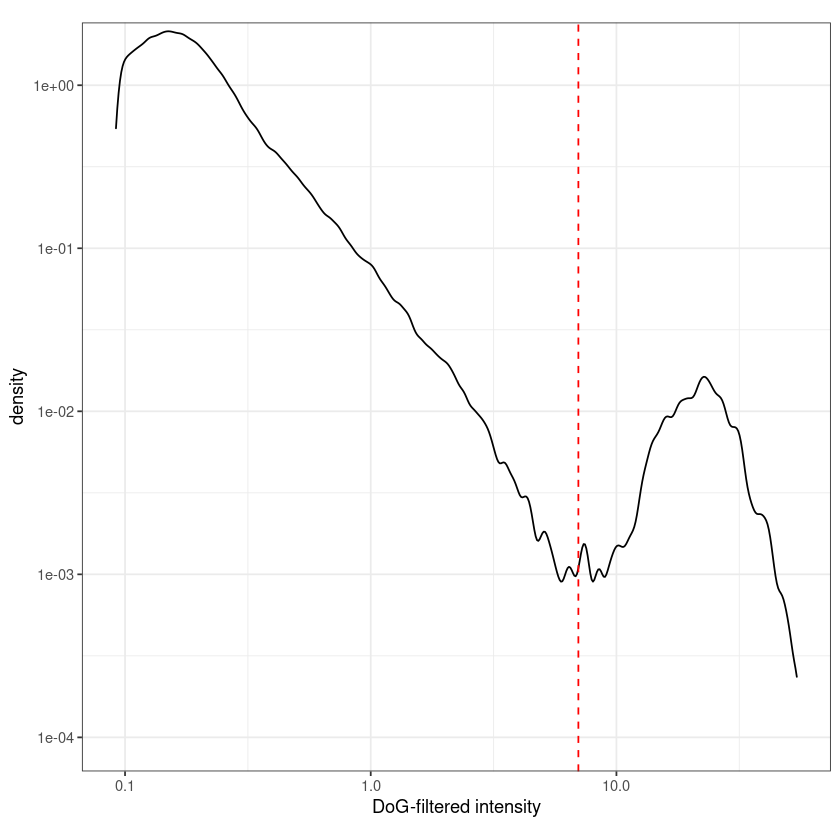

In [7]:
ylim_custom = c(1e-4, 1.5)
p = ggplot(ddata[1 == sid], aes(x=Value2)) + geom_density() + theme_bw() +
    scale_x_log10() + scale_y_log10() + labs(x="DoG-filtered intensity") +
    geom_vline(xintercept=7, color="red", linetype="dashed") +
    coord_fixed(ddata[1==sid, diff(range(log10(Value2)))]/diff(range(log10(ylim_custom))), ylim=ylim_custom)
print(p)

In [8]:
ggsave(plot=p, file="panels/fig_3f.png", width=4, height=4)
saveRDS(p, "panels_rds/fig_3f.rds")

# Panel 3.g: barplot with dot overlap between 60x raw and DW.

In [9]:
counts = fread("../../data/60x_reference/matched_dots.field_thr.counts.tsv")[series_id <= 5]

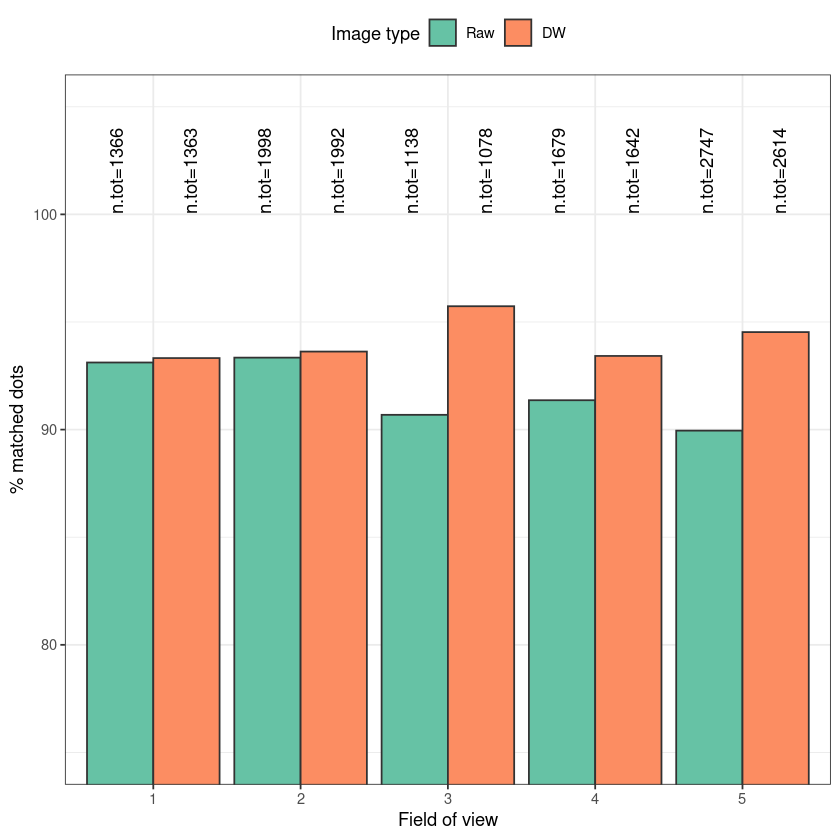

In [10]:
pdata = melt(counts[, .(series_id, raw_matched=matched/raw_total, dw_matched=matched/dw_total)], "series_id")
p = ggplot(pdata, aes(x=factor(series_id), fill=variable, y=value*100)) + geom_col(position="dodge", color="#323232") +
    scale_fill_brewer("Image type", palette="Set2", labels=c("Raw", "DW")) + theme_bw() +
    geom_text(data=counts[, .(series_id, variable="raw_matched", value=1, label=raw_total)],
              aes(label=paste0("n.tot=", label)), angle=90, nudge_x=-.25, hjust=0) +
    geom_text(data=counts[, .(series_id, variable="dw_matched", value=1, label=dw_total)],
              aes(label=paste0("n.tot=", label)), angle=90, nudge_x=+.25, hjust=0) +
    coord_cartesian(ylim=c(75, 105)) + theme(legend.position="top") +
    labs(x="Field of view", y="% matched dots")
print(p)

In [11]:
ggsave(plot=p, file="panels/fig_3g.png", width=4, height=4)
saveRDS(p, "panels_rds/fig_3g.rds")

# Panel 3.h: barplot with dot overlap between 20x and 60x-based reference.

In [12]:
counts_dw = fread("../../data/magnifications_matching/20x_dw.matched_dots.field_thr.counts.tsv",
               col.names=c("series_id", "matched", "matched_over_dist", "total_20x", "total_60x")
              )[series_id <= 5]
counts_dw[, image_type := "dw"]
counts_raw = fread("../../data/magnifications_matching/20x_raw.matched_dots.field_thr.counts.tsv",
               col.names=c("series_id", "matched", "matched_over_dist", "total_20x", "total_60x")
              )[series_id <= 5]
counts_raw[, image_type := "raw"]
counts = rbindlist(list(counts_dw, counts_raw))

In [13]:
pdata = melt(counts[, .(
           matched_20x=sum(matched)/sum(total_20x),
           matched_ref=sum(matched)/sum(total_60x)), by=image_type],
     "image_type")
pdata[, image_type := factor(image_type, levels=c("raw", "dw"))]

In [14]:
totals = counts[, .(total_20x=sum(total_20x), total_60x=sum(total_60x)), by=image_type]

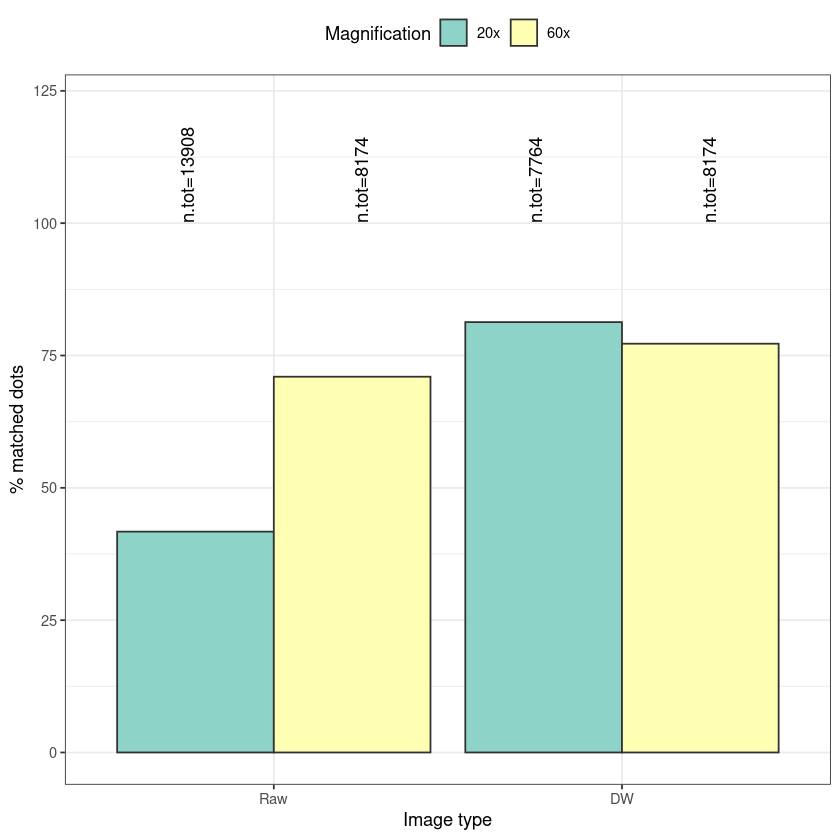

In [15]:
p = ggplot(pdata, aes(x=image_type, fill=variable, y=value*100)) + geom_col(position="dodge", color="#323232") +
    scale_fill_brewer("Magnification", palette="Set3", labels=c("20x", "60x")) + theme_bw() +
    geom_text(data=totals[, .(image_type, variable="matched_20x", value=1, label=total_20x)],
              aes(label=paste0("n.tot=", label)), angle=90, nudge_x=-.25, hjust=0) +
    geom_text(data=totals[, .(image_type, variable="matched_ref", value=1, label=total_60x)],
              aes(label=paste0("n.tot=", label)), angle=90, nudge_x=+.25, hjust=0) +
    scale_x_discrete(labels=c("Raw", "DW")) +
    coord_cartesian(ylim=c(0, 122)) + theme(legend.position="top") +
    labs(x="Image type", y="% matched dots")
print(p)

In [16]:
ggsave(plot=p, file="panels/fig_3h.png", width=4, height=4)
saveRDS(p, "panels_rds/fig_3h.rds")

# Panel X1.a: scatterplot of DoG-filtered intensity (Y) vs SNR (X), for 60x raw field #1.

In [17]:
ddata = dots_data[FWHM >= .5 & FWHM <= 5 & nid > 0]
setkeyv(ddata, c("series_id", "nid"))
ddata = nuclear_features[ddata][!is.na(size)]["60x" == magnification]["raw" == image_type]

In [18]:
ddata[, dot_type := "noisy dots"]
ddata[.18 <= Value2, dot_type := "true dots"]

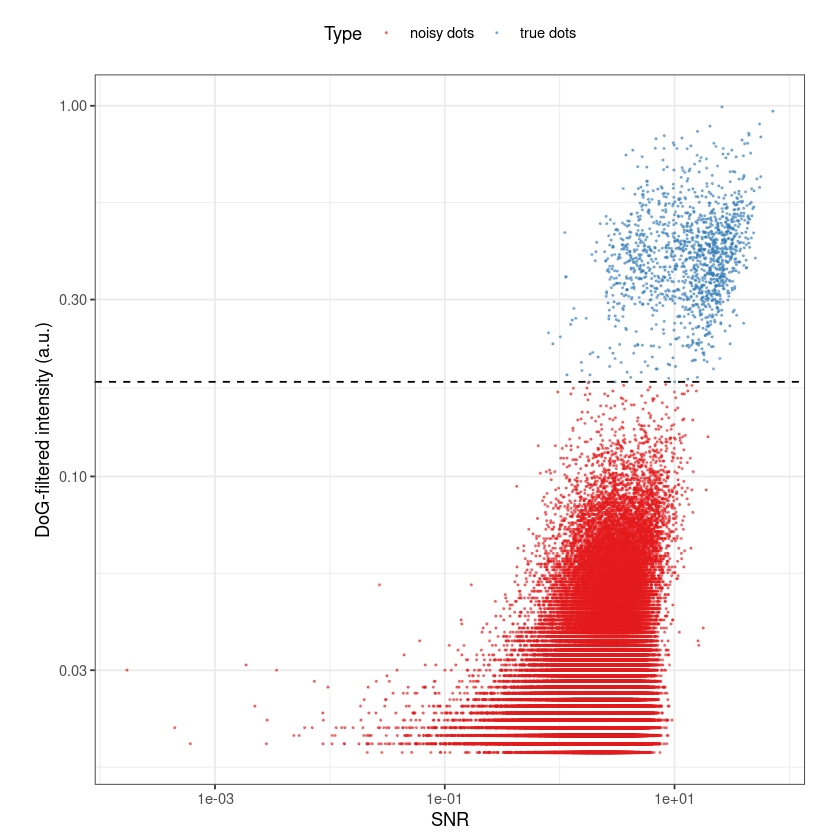

In [19]:
p = ggplot(ddata[1 == sid], aes(x=SNR2, y=Value2)) + geom_point(aes(color=dot_type), size=.25, alpha=.5) + theme_bw() +
    scale_x_log10() + scale_y_log10() + labs(x="SNR", y="DoG-filtered intensity (a.u.)") +
    scale_color_brewer("Type", palette="Set1") + theme(legend.position="top") +
    coord_fixed(ddata[1 == sid, diff(log10(range(SNR2)))/diff(log10(range(Value2)))]) +
    geom_hline(yintercept=.18, color="black", linetype="dashed")
p

In [20]:
ggsave(plot=p, file="panels/supp_fig_x1a.png", width=4, height=4)
saveRDS(p, "panels_rds/supp_fig_x1a.rds")

# Panel X1.b: logged density distribution for threshold identification, in 60x raw field #1.

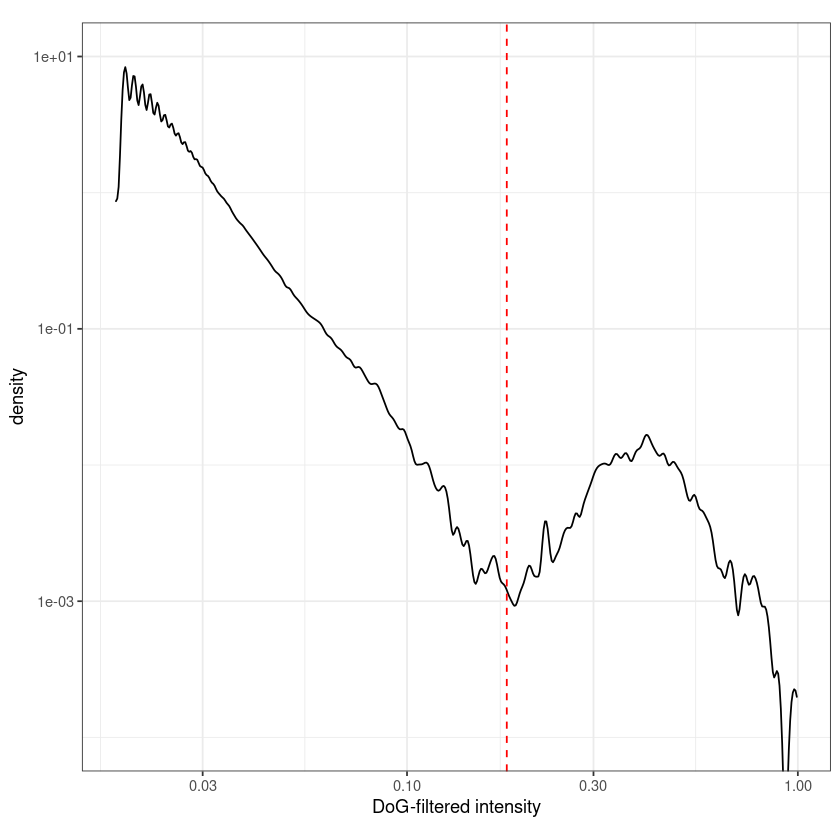

In [21]:
ylim_custom = c(1e-4, 10)
p = ggplot(ddata[1 == sid], aes(x=Value2)) + geom_density() + theme_bw() +
    scale_x_log10() + scale_y_log10() + labs(x="DoG-filtered intensity") +
    geom_vline(xintercept=.18, color="red", linetype="dashed") +
    coord_fixed(ddata[1==sid, diff(range(log10(Value2)))]/diff(range(log10(ylim_custom))), ylim=ylim_custom)
print(p)

In [22]:
ggsave(plot=p, file="panels/supp_fig_x1b.png", width=4, height=4)
saveRDS(p, "panels_rds/supp_fig_x1b.rds")

# Panel X1.c
## FWHM distribution of dots un/filtered by field-based threshold for 60x DW and raw, field #1.

In [23]:
ddata = dots_data[FWHM >= .5 & FWHM <= 5 & nid > 0]
setkeyv(ddata, c("series_id", "nid"))
ddata = nuclear_features[ddata][!is.na(size)]["60x" == magnification]

In [24]:
ddata[, dot_type := "noisy dots"]
ddata["60x" == magnification & "dw" == image_type & 7 <= Value2, dot_type := "true dots"]
ddata["60x" == magnification & "raw" == image_type & .18 <= Value2, dot_type := "true dots"]

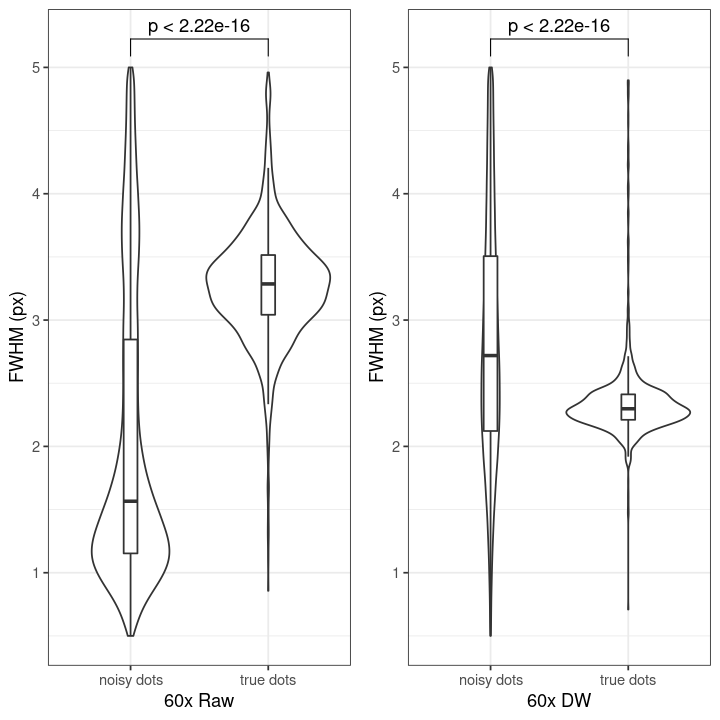

In [25]:
options(repr.plot.width=6, repr.plot.height=6)        
pdata = ddata[1 == sid]
pdata["dw" == image_type, image_type := "DW"]
pdata["raw" == image_type, image_type := "Raw"]
plist = lapply(split(pdata, list(pdata$image_type, pdata$magnification)), function(ppdata) {
    label = ppdata[1, paste0(magnification, " ", image_type)]
    ggplot(ppdata, aes(x=dot_type, y=FWHM)) +
        geom_violin(trim=T) + geom_boxplot(width=.1, outlier.shape=NA) +
        theme_bw() + labs(x=label, y="FWHM (px)") +
        theme(legend.position="bottom") +
        stat_compare_means(method="wilcox.test", comparisons=list(c(1, 2)))
})
p = plot_grid(plotlist=list(plist[[2]], plist[[1]]), nrow=1, align="hv", axis="blrt")
print(p)

In [26]:
ggsave(plot=p, file="panels/supp_fig_x1c.png", width=4, height=4)
saveRDS(p, "panels_rds/supp_fig_x1c.rds")

# Panel X1.d: scatterplot of DoG-filtered intensity (Y) vs SNR (X), for 20x raw field #1.

In [27]:
ddata = dots_data[FWHM >= .5 & FWHM <= 5 & nid > 0]
setkeyv(ddata, c("series_id", "nid"))
ddata = nuclear_features[ddata][!is.na(size)]["20x" == magnification]["raw" == image_type]

In [28]:
ddata[, dot_type := "noisy dots"]
ddata[.095 <= Value2, dot_type := "true dots"]

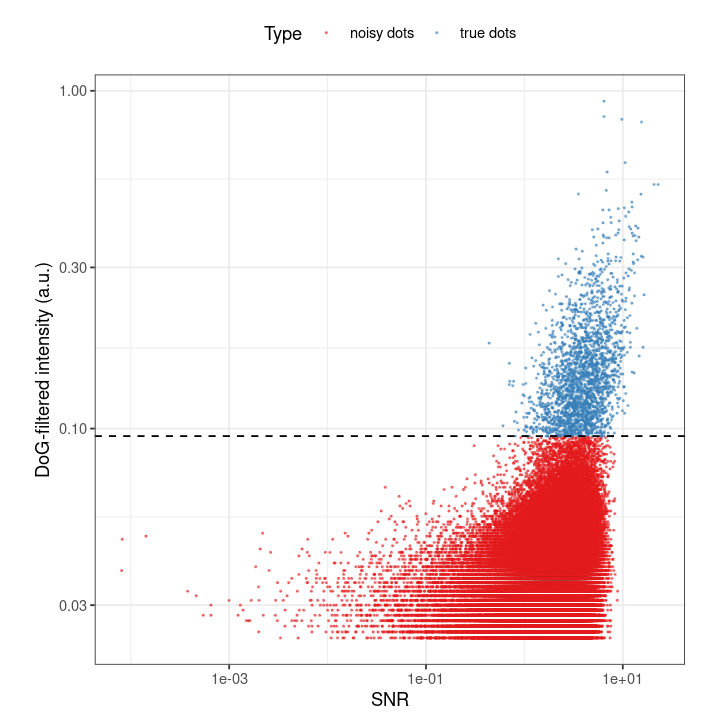

In [29]:
p = ggplot(ddata[1 == sid], aes(x=SNR2, y=Value2)) + geom_point(aes(color=dot_type), size=.25, alpha=.5) + theme_bw() +
    scale_x_log10() + scale_y_log10() + labs(x="SNR", y="DoG-filtered intensity (a.u.)") +
    scale_color_brewer("Type", palette="Set1") + theme(legend.position="top") +
    coord_fixed(ddata[1 == sid, diff(log10(range(SNR2)))/diff(log10(range(Value2)))]) +
    geom_hline(yintercept=.095, color="black", linetype="dashed")
p

In [30]:
ggsave(plot=p, file="panels/supp_fig_x1d.png", width=4, height=4)
saveRDS(p, "panels_rds/supp_fig_x1d.rds")

# Panel X1.e: logged density distribution for threshold identification, in 20x raw field #1.

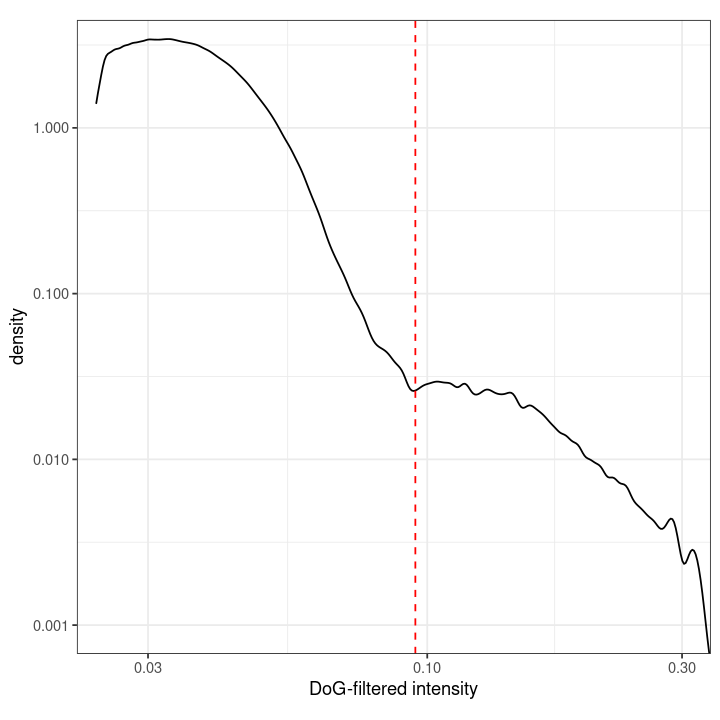

In [31]:
xlim_custom = c(.025, .3)
ylim_custom = c(1e-3, 3)
p = ggplot(ddata[1 == sid], aes(x=Value2)) + geom_density() + theme_bw() +
    scale_x_log10() + scale_y_log10() + labs(x="DoG-filtered intensity") +
    geom_vline(xintercept=.095, color="red", linetype="dashed") +
    coord_fixed(diff(range(log10(xlim_custom)))/diff(range(log10(ylim_custom))), xlim=xlim_custom, ylim=ylim_custom)
print(p)

In [32]:
ggsave(plot=p, file="panels/supp_fig_x1e.png", width=4, height=4)
saveRDS(p, "panels_rds/supp_fig_x1e.rds")

# Panel X1.f: scatterplot of DoG-filtered intensity (Y) vs SNR (X), for 20x DW field #1.

In [33]:
ddata = dots_data[FWHM >= .5 & FWHM <= 5 & nid > 0]
setkeyv(ddata, c("series_id", "nid"))
ddata = nuclear_features[ddata][!is.na(size)]["20x" == magnification]["dw" == image_type]

In [34]:
ddata[, dot_type := "noisy dots"]
ddata[11 <= Value2, dot_type := "true dots"]

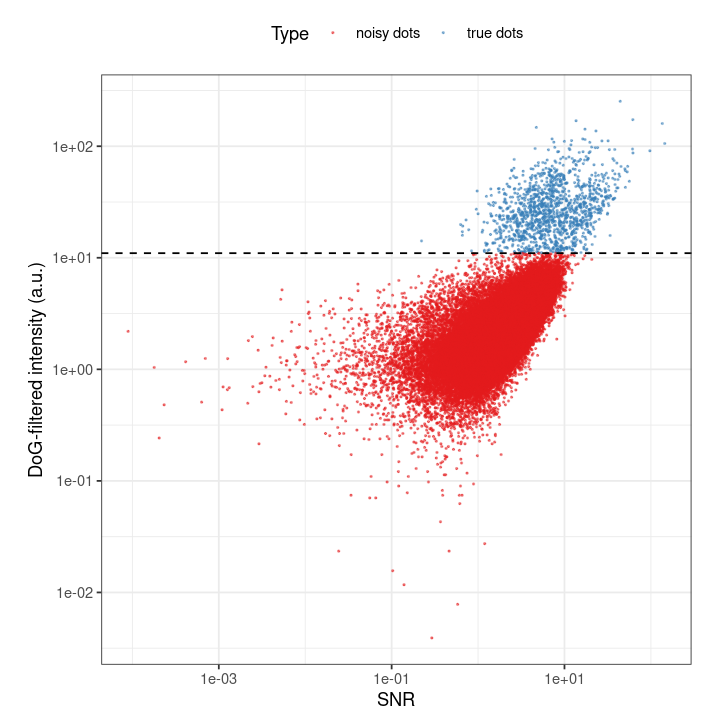

In [35]:
p = ggplot(ddata[1 == sid], aes(x=SNR2, y=Value2)) + geom_point(aes(color=dot_type), size=.25, alpha=.5) + theme_bw() +
    scale_x_log10() + scale_y_log10() + labs(x="SNR", y="DoG-filtered intensity (a.u.)") +
    scale_color_brewer("Type", palette="Set1") + theme(legend.position="top") +
    coord_fixed(ddata[1 == sid, diff(log10(range(SNR2)))/diff(log10(range(Value2)))]) +
    geom_hline(yintercept=11, color="black", linetype="dashed")
p

In [36]:
ggsave(plot=p, file="panels/supp_fig_x1f.png", width=4, height=4)
saveRDS(p, "panels_rds/supp_fig_x1f.rds")

# Panel X1.g: logged density distribution for threshold identification, in 20x DW field #1.

Warning message:
“Transformation introduced infinite values in continuous y-axis”


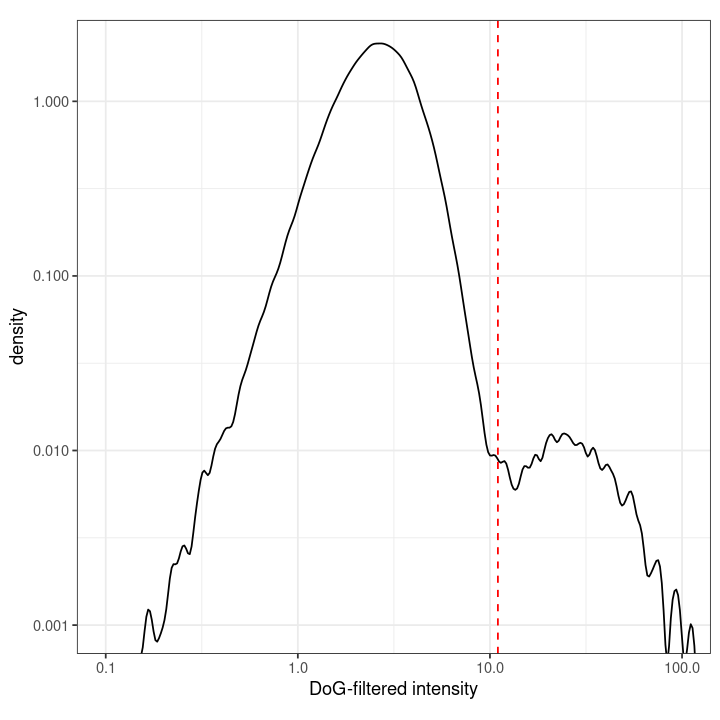

In [37]:
xlim_custom = c(1e-1, 1e2)
ylim_custom = c(1e-3, 2)
p = ggplot(ddata[1 == sid], aes(x=Value2)) + geom_density() + theme_bw() +
    scale_x_log10() + scale_y_log10() + labs(x="DoG-filtered intensity") +
    geom_vline(xintercept=11, color="red", linetype="dashed") +
    coord_fixed(diff(range(log10(xlim_custom)))/diff(range(log10(ylim_custom))), xlim=xlim_custom, ylim=ylim_custom)
print(p)

In [38]:
ggsave(plot=p, file="panels/supp_fig_x1g.png", width=4, height=4)
saveRDS(p, "panels_rds/supp_fig_x1g.rds")

Warning message:
“Transformation introduced infinite values in continuous y-axis”


# Panel X1.h
## FWHM distribution of dots un/filtered by field-based threshold for 20x DW and raw, field #1.

In [39]:
ddata = dots_data[FWHM >= .5 & FWHM <= 5 & nid > 0]
setkeyv(ddata, c("series_id", "nid"))
ddata = nuclear_features[ddata][!is.na(size)]["20x" == magnification]

In [40]:
ddata[, dot_type := "noisy dots"]
ddata["20x" == magnification & "dw" == image_type & 11 <= Value2, dot_type := "true dots"]
ddata["20x" == magnification & "raw" == image_type & .095 <= Value2, dot_type := "true dots"]

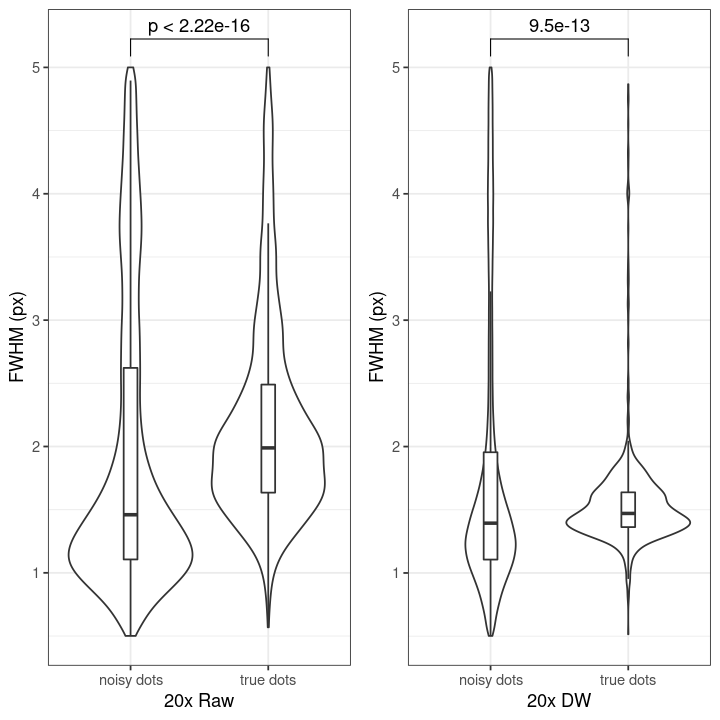

In [41]:
options(repr.plot.width=6, repr.plot.height=6)        
pdata = ddata[1 == sid]
pdata["dw" == image_type, image_type := "DW"]
pdata["raw" == image_type, image_type := "Raw"]
plist = lapply(split(pdata, list(pdata$image_type, pdata$magnification)), function(ppdata) {
    label = ppdata[1, paste0(magnification, " ", image_type)]
    ggplot(ppdata, aes(x=dot_type, y=FWHM)) +
        geom_violin(trim=T) + geom_boxplot(width=.1, outlier.shape=NA) +
        theme_bw() + labs(x=label, y="FWHM (px)") +
        theme(legend.position="bottom") +
        stat_compare_means(method="wilcox.test", comparisons=list(c(1, 2)))
})
p = plot_grid(plotlist=list(plist[[2]], plist[[1]]), nrow=1, align="hv", axis="blrt")
print(p)

In [42]:
ggsave(plot=p, file="panels/supp_fig_x1h.png", width=4, height=4)
saveRDS(p, "panels_rds/supp_fig_x1h.rds")